In [1]:
import os
import sys
sys.path.insert(0, '..')

from google.cloud import bigquery
from google.oauth2 import service_account

from google.cloud import bigquery
from google.oauth2 import service_account

import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np

from authenticate_service_account import main
from utils import *


In [2]:
client = main()

query = """
SELECT *
FROM skyscanner-insights-343713.Itinerary_Scoring.top_10_ods
"""

query_job = client.query(query)

results = query_job.result()


In [3]:
data = results.to_dataframe()


In [4]:
data.columns


Index(['OriginApt', 'OriginCty', 'OriginCtry', 'DestinationApt',
       'DestinationCty', 'DestinationCtry', 'TravelHorizonDays',
       'TravelDistanceKm', 'SelfTransfer', 'Stops', 'DurationMin',
       'Seg_0_OriginIATA', 'Seg_0_OriginName', 'Seg_0_DestinationIATA',
       'Seg_0_DestinationName', 'Seg_0_OperatingCarrierIATA',
       'Seg_0_TravelDistanceKm', 'Seg_1_OriginIATA', 'Seg_1_OriginName',
       'Seg_1_DestinationIATA', 'Seg_1_DestinationName',
       'Seg_1_OperatingCarrierIATA', 'Seg_1_TravelDistanceKm',
       'Seg_2_OriginIATA', 'Seg_2_OriginName', 'Seg_2_DestinationIATA',
       'Seg_2_DestinationName', 'Seg_2_OperatingCarrierIATA',
       'Seg_2_TravelDistanceKm', 'Seg_3_OriginIATA', 'Seg_3_OriginName',
       'Seg_3_DestinationIATA', 'Seg_3_DestinationName',
       'Seg_3_OperatingCarrierIATA', 'Seg_3_TravelDistanceKm',
       'Seg_0_DurationMin', 'Seg_1_DurationMin', 'Seg_2_DurationMin',
       'Seg_3_DurationMin', 'passengers', 'SearchLowestRatio',
       'ItinLowe

In [5]:
def create_od_column(df, raw_od_columns):
    df['OD'] = df[raw_od_columns[0]] + df[raw_od_columns[1]]

    return df


In [6]:
data_with_od = create_od_column(data, ['OriginCty', 'DestinationCty'])


In [7]:
columns_for_model = ['OD', 'TravelDistanceKm', 'Stops', 'TravelHorizonDays',
                     'Seg_0_TravelDistanceKm', 'Seg_1_TravelDistanceKm', 'Seg_2_TravelDistanceKm', 'Seg_3_TravelDistanceKm',
                     'ItineraryRedirects', 'ODRedirects',
                     'Seg_0_DurationMin' ,'Seg_1_DurationMin', 'Seg_2_DurationMin', 'Seg_3_DurationMin', 'DurationMin']


In [8]:
model_data = data_with_od[columns_for_model].copy()
model_data


,OD,TravelDistanceKm,Stops,TravelHorizonDays,Seg_0_TravelDistanceKm,Seg_1_TravelDistanceKm,Seg_2_TravelDistanceKm,Seg_3_TravelDistanceKm,ItineraryRedirects,ODRedirects,Seg_0_DurationMin,Seg_1_DurationMin,Seg_2_DurationMin,Seg_3_DurationMin,DurationMin
0,DELBOM,1140,0,180,1140,<NA>,<NA>,<NA>,5,5,135.0,NaN,NaN,NaN,135
1,HKGBKK,1689,0,279,1689,<NA>,<NA>,<NA>,4,5,175.0,NaN,NaN,NaN,175
2,HKGBKK,1689,0,279,1689,<NA>,<NA>,<NA>,1,5,195.0,NaN,NaN,NaN,195
3,HKGTPE,806,0,136,806,<NA>,<NA>,<NA>,4,37,100.0,NaN,NaN,NaN,100
4,HKGTPE,806,0,136,806,<NA>,<NA>,<NA>,3,37,115.0,NaN,NaN,NaN,115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28164,TYOBKK,4648,0,138,4648,<NA>,<NA>,<NA>,7,21,430.0,NaN,NaN,NaN,430
28165,TYOBKK,4648,1,138,1257,3668,<NA>,<NA>,1,21,150.0,360.0,NaN,NaN,780
28166,TYOBKK,4648,1,138,1257,3668,<NA>,<NA>,1,21,150.0,335.0,NaN,NaN,645
28167,TYOBKK,4648,1,340,5357,1416,<NA>,<NA>,1,2,430.0,150.0,NaN,NaN,650


In [9]:
data_with_layover = calculate_total_layover_time(model_data)


In [10]:
clean_data = drop_neg_layover_time(data_with_layover)


<Axes: >

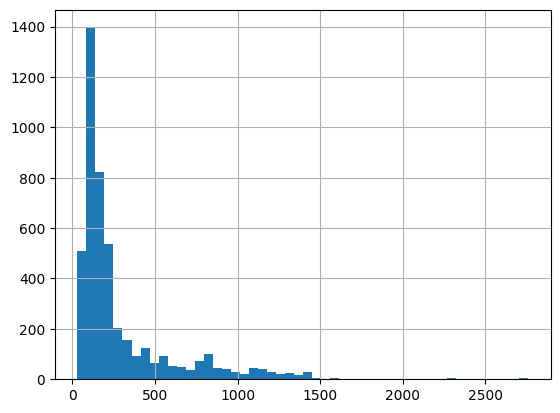

In [11]:

clean_data[clean_data['total_layover_time'] > 0]['total_layover_time'].hist(bins=50)


In [12]:
sorted_data = clean_data[clean_data['total_layover_time'] > 0]['total_layover_time'].sort_values()
cumulative = np.arange(1, len(sorted_data) +1) / len(sorted_data)


Text(0, 0.5, '% share of the data')

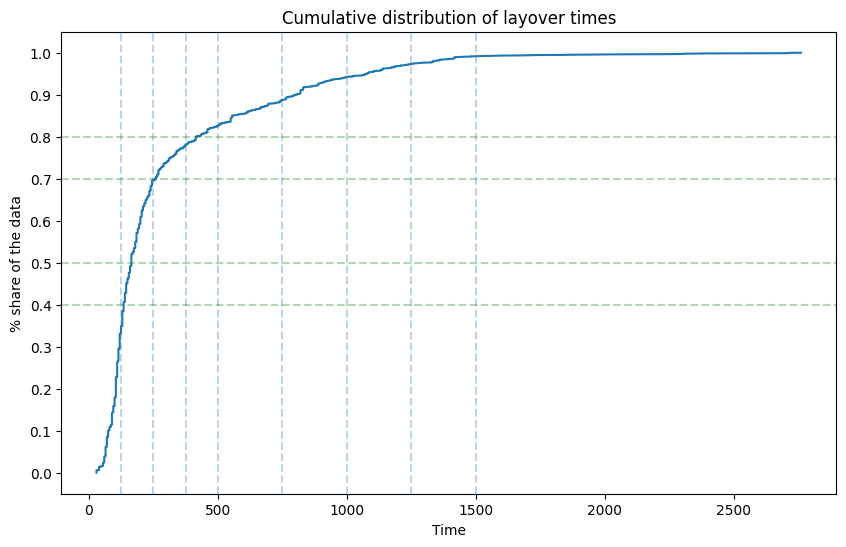

In [13]:
plt.figure(figsize=(10,6))
plt.plot(sorted_data, cumulative)
plt.yticks(np.linspace(0, 1, 11))
x_values = [125, 250, 375, 500, 750, 1000, 1250, 1500]  # Replace x1, x2, x3 with your specific values
for x in x_values:
    plt.axvline(x=x, linestyle='--', alpha=0.3)

y_values = [0.4, 0.5, 0.7, 0.8]
for y in y_values:
    plt.axhline(y=y, color='green', linestyle='--', alpha=0.3)

plt.title("Cumulative distribution of layover times")
plt.xlabel('Time')
plt.ylabel('% share of the data')
